In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [7]:

import torch
print(torch.__version__)

2.5.1+cu121


In [8]:
class MNIST_data(Dataset):
    """MNIST dtaa set"""
    
    def __init__(self, file_path, 
                 transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), 
                     transforms.Normalize(mean=(0.5,), std=(0.5,))])
                ):
        
        df = pd.read_csv(file_path)
        
        if len(df.columns) == 784:
            # test data
            self.X = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
            
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

In [9]:
batch_size = 64

train_dataset = MNIST_data('/kaggle/input/digit-recognizer/train.csv', transform= transforms.Compose(
                            [transforms.ToPILImage(), transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))]))
test_dataset = MNIST_data('/kaggle/input/digit-recognizer/test.csv')


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, shuffle=False)

model size:
12906 parameters


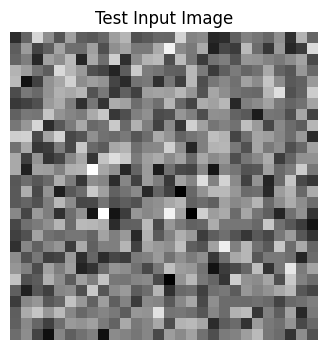

Input shape: torch.Size([1, 1, 28, 28])
Predicted digit: 9
Output probabilities: [0.0859375  0.03125    0.0703125  0.0625     0.109375   0.0390625
 0.01953125 0.06640625 0.046875   0.46484375]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1844: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return inner()


In [10]:



class OptimizedCNN(nn.Module):
    def __init__(self):
        super(OptimizedCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),  # Reduced filters and kernel size
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),  # Reduced filters and kernel size
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 5 * 5, 10),
            nn.Softmax()
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc(x)
        return x

model = OptimizedCNN()

model.qconfig = torch.quantization.default_qconfig
model_prepared = torch.quantization.prepare_qat(model)

print("model size:")
print(sum(p.numel() for p in model_prepared.parameters() if p.requires_grad), "parameters")

# Create a test input (28x28 grayscale image)
test_input = torch.randn(1, 1, 28, 28)  # Batch size 1, 1 channel, 28x28 pixels

# Display the test input
plt.figure(figsize=(4, 4))
plt.imshow(test_input[0, 0].numpy(), cmap='gray')
plt.axis('off')
plt.title('Test Input Image')
plt.show()

# Print input shape
print(f"Input shape: {test_input.shape}")

# Test the model with the input
with torch.no_grad():
    output = model_prepared(test_input)
    predicted_digit = torch.argmax(output).item()
    print(f"Predicted digit: {predicted_digit}")
    print(f"Output probabilities: {output[0].numpy()}")

In [11]:
model_prepared

OptimizedCNN(
  (conv1): Sequential(
    (0): Conv2d(
      1, 16, kernel_size=(3, 3), stride=(1, 1)
      (weight_fake_quant): MinMaxObserver(min_val=-0.33276236057281494, max_val=0.32955655455589294)
      (activation_post_process): MinMaxObserver(min_val=-2.4491498470306396, max_val=2.510695219039917)
    )
    (1): BatchNorm2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (activation_post_process): MinMaxObserver(min_val=-3.6879217624664307, max_val=3.7476508617401123)
    )
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(
      16, 32, kernel_size=(3, 3), stride=(1, 1)
      (weight_fake_quant): MinMaxObserver(min_val=-0.083328977227211, max_val=0.08331044018268585)
      (activation_post_process): MinMaxObserver(min_val=-2.461416482925415, max_val=2.594917058944702)
    )
    (1): BatchNorm2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [12]:

# if(torch.cuda.is_available()):
#     model_prepared = model_prepared.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_prepared.parameters(), lr=0.001, momentum=0.9)

In [13]:
import time

print('Training....')
total = 0
correct = 0
start = time.time()

for epoch in range(40):
    
    for i, data in enumerate(train_loader, 1):
        images, labels = data

        #if(torch.cuda.is_available()):
        # images = images.cuda()
        # labels = labels.cuda()

        optimizer.zero_grad()    
        outputs = model_prepared(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        if(i%100 == 0):
            print('Epoch: {} Batch: {} loss: {}'.format(epoch, i, loss.item()))

        loss.backward()
        optimizer.step()

model_int8 = torch.quantization.convert(model_prepared)

print('Training Completed in: {} secs'.format(time.time()-start))
print('Training accuracy: {} %'.format((correct/total)*100))

        

Training....
Epoch: 0 Batch: 100 loss: 2.120450735092163
Epoch: 0 Batch: 200 loss: 1.8638532161712646
Epoch: 0 Batch: 300 loss: 1.7470965385437012
Epoch: 0 Batch: 400 loss: 1.7991697788238525
Epoch: 0 Batch: 500 loss: 1.69730544090271
Epoch: 0 Batch: 600 loss: 1.7072259187698364
Epoch: 1 Batch: 100 loss: 1.6724646091461182
Epoch: 1 Batch: 200 loss: 1.6629966497421265
Epoch: 1 Batch: 300 loss: 1.6116080284118652
Epoch: 1 Batch: 400 loss: 1.6446120738983154
Epoch: 1 Batch: 500 loss: 1.6088331937789917
Epoch: 1 Batch: 600 loss: 1.5998561382293701
Epoch: 2 Batch: 100 loss: 1.6459248065948486
Epoch: 2 Batch: 200 loss: 1.6953494548797607
Epoch: 2 Batch: 300 loss: 1.5828557014465332
Epoch: 2 Batch: 400 loss: 1.5574270486831665
Epoch: 2 Batch: 500 loss: 1.6122158765792847
Epoch: 2 Batch: 600 loss: 1.6902621984481812
Epoch: 3 Batch: 100 loss: 1.5719926357269287
Epoch: 3 Batch: 200 loss: 1.6234921216964722
Epoch: 3 Batch: 300 loss: 1.6299961805343628
Epoch: 3 Batch: 400 loss: 1.5670894384384155


In [16]:
print('Predicting....')
start = time.time()

predictions = torch.LongTensor()
for i, data in enumerate(test_loader, 1):
    data = data
    
    if(i%100 == 0):
        print('Batch {} done'.format(i))
    outputs = model(data)
    
    pred = outputs.data.max(1, keepdim=True)[1]
    predictions = torch.cat((predictions, pred), dim=0)
    
print('Completed in {} secs'.format(time.time() - start))

Predicting....


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Batch 100 done
Batch 200 done
Batch 300 done
Batch 400 done
Completed in 9.553915023803711 secs


In [17]:
# Quantize model

model_int8 = torch.quantization.convert(model, inplace=False)

# Save the quantized model
torch.save(model_int8, '/kaggle/working/model_dynamic_quantized.pth')

In [ ]:
import os

def get_file_size_kb(file_path):
  """
    Retrieves the size of a file in kilobytes.

    Args:
        file_path: The path to the file.

    Returns:
        The file size in kilobytes, or None if the file does not exist.
    """
  try:
    size_bytes = os.path.getsize(file_path)
    size_kb = size_bytes / 1024
    return size_kb
  except FileNotFoundError:
    return None

# Example usage:
file_path = "model_dynamic_quantized.pth"  # Replace with your file path
file_size_kb = get_file_size_kb(file_path)

if file_size_kb is not None:
  print(f"The size of '{file_path}' is: {file_size_kb:.2f} KB")
else:
  print(f"File '{file_path}' not found.")

In [ ]:
import torchvision.datasets as datasets

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Sample a random image from MNIST
sample_idx = torch.randint(0, len(mnist_dataset), (1,)).item()
sample_image, sample_label = mnist_dataset[sample_idx]

# Display the image
plt.figure(figsize=(4, 4))
plt.imshow(sample_image[0].numpy(), cmap='gray')
plt.axis('off')
plt.title(f'True Label: {sample_label}')
plt.show()

# Prepare the image for the model (add batch dimension)
model_input = sample_image.unsqueeze(0)

# Get model prediction
with torch.no_grad():
    output = model_optimized(model_input)
    predicted_digit = torch.argmax(output).item()
    probabilities = output[0].numpy()
    
    print(f"True Label: {sample_label}")
    print(f"Predicted Label: {predicted_digit}")
    print("\nProbabilities for each digit:")
    for i, prob in enumerate(probabilities):
        print(f"Digit {i}: {prob:.2%}")

In [ ]:
out_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], predictions.numpy()], columns=['ImageId', 'Label'])

In [ ]:
out_df.to_csv('submission.csv', index=False)

In [ ]:
out_df.head()